## TRAINING AUGMENTED INTERPOLATION 

In [168]:
import os


import torch
import torch.nn as nn
from torch.autograd import Variable

try:
    import torchinfo
    no_torchinfo = False
except ModuleNotFoundError:
    no_torchinfo = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

torch loaded; device is cpu


# PINNs Advection Equation

This notebook solves the advection-diffusion equation using a physics-informed neural network (PINN). The equation is given by:

\begin{cases}
\partial_t u + a \partial_x u = 0 \\
u(t=0, x) = u_0(x, \mu)
\end{cases}

where $u$ is the dependent variable, $t$ is time, $x$ is space, and $a$ is the diffusion coefficient (velocity) The initial condition is given by:

\begin{equation}
u_0(x) = \exp(-(x-\mu)^2/\sigma)
\end{equation}

Where $\mu$ is the mean and $\sigma$ is the variance. The solution is given by:

\begin{equation}
u(x,t) = u_0(x-a*t)
\end{equation}

## Analysis:

### Neural Network
A neural network is a function that maps an input $X$ to an output $Y$ by performing successive linear and nonlinear transformations. The linear transformations are represented by a set of weights $W$ and biases $b$ and the nonlinear transformations are represented by activation functions $\sigma$. The output of a neural network is given by:

$$\overline{u_\theta}(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

We will train our NN by iteratively minimizing a loss function ($MSE$:mean squared error) in the training dataset. 

### Physics Informed Neural Network = NN + PDE

We can use a neural network to approximate any function (Universal Approximation Theorem). In our case, we want to approximate the solution of a PDE. We can do this by minimizing the error of the PDE in a certain number of points inside our domain.

$$\overline{u_\theta}\approx u(x,t)$$ 

Since NN is a function, we can obtain its derivatives: $\frac{\partial \overline{u_\theta}}{\partial t},\frac{\partial \overline{u_\theta}}{\partial x}$.

We assume then: $$\overline{u_\theta}(x,t)\approx u(x,t,\theta)$$ 

Then:

$$\left(\frac{\partial\overline{u_\theta}}{\partial t} + a \frac{\partial \overline{u_\theta}}{\partial x}\right) \approx \left(\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x}\right) =0$$

And:

$$\left(\frac{\partial\overline{u_\theta}}{\partial t} + a\frac{\partial \overline{u_\theta} }{\partial x}\right) \approx 0$$

We should also define the boundary conditions both in time as it follows:

<!-- boundary conditions in space:

$$bc_{space}(x)=x*(x-1)$$ -->

boundary conditions in time:
$$bc_{time}(t)=t$$

Now we can define this function as $u_\theta$:

$${u_\theta}(x,t)= u_{0}(x)+ bc_{time}(t) * bc_{space}(x) * \overline{u_\theta}(x,t)$$ 

If $u_\theta \rightarrow 0$ then our $\overline{u_\theta}$ would be respecting the physical law.

### PINNs' Loss function

We evaluate our PDE in a certain number of "collocation points" ($N_{coll}$) inside our domain $(x,t)$, and we try also to guess the values of $\mu$ and $\sigma$ of our initial condition adding also collocation points to these parameters ($N_{\mu}$ and $N_{\sigma}$). 

Then we iteratively minimize a loss function related to $u_\theta$:

$$MSE_{u_\theta}=\frac{1}{N_{coll}}\sum^{N_{coll}}_{i=1}|u_\theta(t_{coll}^i,x_{coll}^i,\mu_{coll}^i,\sigma_{coll}^i)|^2$$

Since we know the outcome, we select $N_u$ points from our BC and IC and used them to train our network.

$$MSE_{u_{exact}}=\frac{1}{N_{u_{exact}}}\sum^{N_{u_{exact}}}_{i=1}|u(t_{u_{exact}}^i,x_{u_{exact}}^i, \mu_{u_{exact}}^i,\sigma_{u_{exact}}^i
)-\overline{u_\theta}(t_{u_{exact}}^i,x_{u_{exact}}^i, \mu_{u_{exact}}^i,\sigma_{u_{exact}}^i)|^2$$


#### Total Loss:

$$MSE=MSE_{u_{exact}}+MSE_{u_\theta}$$

We are looking to minimize:
$$
\Theta* = argmin_\Theta \left\{ \frac{1}{N_{coll}}\sum^{N_{coll}}_{i=1}|u_\theta(t_{coll}^i,x_{coll}^i,\mu_{coll}^i,\sigma_{coll}^i)|^2 + \frac{1}{N_{u_{exact}}}\sum^{N_{u_{exact}}}_{i=1}|u(t_{u_{exact}}^i,x_{u_{exact}}^i, \mu_{u_{exact}}^i,\sigma_{u_{exact}}^i
)-\overline{u_\theta}(t_{u_{exact}}^i,x_{u_{exact}}^i, \mu_{u_{exact}}^i,\sigma_{u_{exact}}^i)|^2 \right\} $$

where $u_\theta$ is the PDE and $u$ is the exact solution.

## Neural Network 

The Net class represents a neural network model. It inherits from nn.DataParallel, which is a PyTorch module used for parallelizing the computation on multiple GPUs.

- `__init__()`: This method is the constructor of the class. It initializes the neural network layers and defines the architecture. The network consists of four hidden layers with 30 units each, followed by an output layer with 10 units. Each layer is defined using the nn.Linear module. The double() method is used to specify the data type as double precision.

- `forward(x, t, mean, variance)`: This method defines the forward pass of the neural network. It takes input tensors x, t, mean, and variance, and applies a sequence of operations to produce the output of the network. The input tensors are concatenated ant the concatenated tensor is then passed through each hidden layer, with a non-linear activation function (tanh) applied after each layer. Finally, the output layer produces the final output of the network.

- `network_BC(t)`: This function serves to impose hard boundary constraints.

In [169]:
class Net(nn.Module):

    """Defines the neural network model"""
    def __init__(self):

        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(4, 30).double()
        self.hidden_layer2 = nn.Linear(30, 30).double()
        self.hidden_layer3 = nn.Linear(30, 30).double()
        self.hidden_layer4 = nn.Linear(30, 10).double()
        self.hidden_layer5 = nn.Linear(10, 5).double()
        self.output_layer = nn.Linear(5, 1).double()

    """Defines the sequence of operations that are applied to the input tensors to produce the output of the neural network"""
    def forward(self, x, t, mean, variance):

        inputs = torch.cat([x,t,mean,variance], axis=1)
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

def network_BC(t): #t to define u_theta
    return t

## Parameters

The Parameters class defines the set of parameters for our PINN.

- `__init__(tf, file_name)`: This method is the constructor of the class. It initializes the parameters:
  - `xmin and xmax`: They represent the minimum and maximum values for the space domain  
  - `tmin and tmax`: They represent the minimum and maximum values for the time domain,
  - `a`: It represents the constant velocity of the wave (diffusion coefficient)
  - `learning_rate`: It represents the learning rate for optimization algorithm.
  - `file_name`: It represents the name of a file that will contain the trained model. 
  - `min_mean and  max_mean`: They represent the minimum and maximum value that the mean variable that the Gaussian initial condition can take. 
  - `min_variance and max_variance`: They represent the minimum and maximum value that the variance variable of the Gaussian initial condition can take. 

- `u0(x, mean, variance)`: This method defines an initial condition function u0 that takes inputs x, mean, and variance.

In [170]:
class Parameters:
   def __init__(self, tf, file_name):
        self.xmin = 0.
        self.xmax = 1.
        self.tmin = 0.
        self.tmax = tf
        self.a = 1.
        self.learning_rate = 1e-3 #1e-3
        self.file_name = file_name
        self.min_mean = 0.45
        self.max_mean = 0.55
        self.min_variance = 0.01
        self.max_variance = 0.05
     
   def u0(self,x,mean,variance):
        return torch.exp(-(x-mean)**2/variance)

## PINN 

The Network class represents a PINN:

- `__init__(param: Parameters)`: Initializes the neural network model and loads the model if available:
  - `parameters`: An instance of the Parameters class that holds various parameters for the network.
- `__call__(*args)`: Calls the network and returns the output.
- `create_network()`: Creates the neural network model using the Net class.
- `load(file_name)`: Loads the model from a file.
- `save(file_name, epoch, net_state, optimizer_state, loss, loss_history)`: Saves the model with the specific values passed as arguments into a file.
- `pde(x, t, mean, variance)`: Computes the PDE using the network and returns the result.
- `predict_u_from_torch(x, t, mean, variance)`: Predicts the value of the solution given by the neural network based on the input variables x, t, mean, and variance.
- `random(min_value, max_value, shape, requires_grad=False, device=device)`: Generates random numbers within a range.
- `make_data(n_data)`: Generates the data of size n_data for the training processbased on the exact solution of the PDE.
- `make_collocation(n_collocation)`: Generates n_collocation collocation points to enforce PDE constraints during training.
- `train(epochs, n_collocation, n_data)`: Trains the neural network using a combination of PDE constraints and data fitting.
- `u_exact(x, t, a, xmax, u0, mean, variance, device=device)`: Computes the exact solution for the PDE.
- `plot(t, mean, variance)`: Plots the loss history, predicted solution, and prediction error at the input variables x, t, mean, and variance.
- `animate(mean, variance)`: Creates an animation of the solution with initial condition with inputs mean and variance. 

In [171]:
class Network:

    def __init__(self,param: Parameters):

        """Initializes the neural network model"""
        self.parameters = param 
        self.x_min, self.x_max = param.xmin, param.xmax
        self.t_min, self.t_max = param.tmin, param.tmax
        self.learning_rate = param.learning_rate
        self.u0 = param.u0
        self.tf = param.tmax
        self.a = param.a
        self.file_name = param.file_name
        self.min_mean, self.max_mean = param.min_mean, param.max_mean
        self.min_variance, self.max_variance = param.min_variance, param.max_variance

        #To save the model
        script_dir = os.getcwd()
        self.file_name = os.path.join(script_dir, self.file_name)

        self.create_network() #Returns the current working directory
        self.load(self.file_name)
        
    """This method calls the neural network model"""
    def __call__(self, *args):
        return self.net(*args)

    def create_network(self):
        """Creates the neural network model"""
        self.net = nn.DataParallel(Net()).to(device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)
   
    def load(self, file_name):
        self.loss_history = []
        try:

            try:
                checkpoint = checkpoint = torch.load(file_name, map_location=torch.device('cpu'))
                
            except RuntimeError:
                checkpoint = torch.load(file_name, map_location=torch.device('cpu'))

            self.net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.loss = checkpoint['loss']

            try:
                self.loss_history = checkpoint['loss_history']
            except KeyError:
                pass

            self.to_be_trained = False
            print("network loaded successfully")
    
        except FileNotFoundError:

            self.to_be_trained = True
            print("network was not loaded from file: training needed")
    
    @staticmethod
    def save(file_name, epoch, net_state, optimizer_state, loss, loss_history):
        torch.save({
            epoch: epoch,
            'model_state_dict': net_state,
            'optimizer_state_dict': optimizer_state,
            'loss': loss,
            'loss_history': loss_history,
        }, file_name)

    def pde(self, x, t, mean, variance):

        u = self.u0(x, mean, variance) + network_BC(t) * self(x, t, mean, variance)
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0] 
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0] 
        
        return u_t + self.a * u_x

    
    """This method predicts the value of u based on the given input variables x, t and u0"""

    def predict_u_from_torch(self, x, t, mean, variance):
        ones = torch.ones(x.shape, dtype=torch.double, device=device)
        pt_mean = mean * ones
        pt_variance = variance * ones
        pt_t = t * ones
        pred = self.u0(x, pt_mean, pt_variance) + network_BC(pt_t) * self(x, pt_t, pt_mean, pt_variance)

        return pred
    
    @staticmethod
    def random(min_value, max_value, shape, requires_grad=False, device=device):
        random_numbers = torch.rand(shape, device=device, dtype=torch.double, requires_grad=requires_grad)
        return min_value + (max_value - min_value) * random_numbers
    
    """This method generates the data for the training process"""
    def make_data(self, n_data):
        
        shape = (n_data, 1)
        """We generate for each variable a random number between the min and max value"""
        self.x_data = Network.random(self.x_min, self.x_max, shape)
        self.t_data = Network.random(self.t_min, self.t_max, shape)
        self.mean_data = Network.random(self.min_mean, self.max_mean, shape)
        self.variance_data = Network.random(self.min_variance, self.max_variance, shape)
        
        self.u_data_exact = Network.u_exact(self.x_data, self.t_data, self.a ,self.x_max, self.u0, self.mean_data, self.variance_data)
        self.zeros1 = torch.zeros(shape, dtype=torch.double, device=device) 
        
    """This method generates the collocation points for the training process to enforce 
       the partial differential equation (PDE) constraints during training."""
    
    def make_collocation(self, n_collocation):

        shape = (n_collocation, 1)
        self.x_collocation = Network.random(self.x_min, self.x_max, shape, requires_grad=True)
        self.t_collocation = Network.random(self.t_min, self.t_max, shape, requires_grad=True)
        self.mean_collocation = Network.random(self.min_mean, self.max_mean, shape, requires_grad=True)
        self.variance_collocation = Network.random(self.min_variance, self.max_variance, shape, requires_grad=True)

        self.zeros = torch.zeros(shape, dtype=torch.double, device=device) 

    """This method trains the neural network using a combination of PDE constraints and data fitting."""
    def train(self, epochs, n_collocation, n_data):

        mse_cost_function = torch.nn.MSELoss()

        try:
            best_loss_value = self.loss.item()
        except AttributeError:
            best_loss_value = 1e10

        for epoch in range(epochs):

            self.optimizer.zero_grad()

            self.loss = 0


            if n_collocation > 0:
                # Loss based on PDE constraints 
                self.make_collocation(n_collocation)
                f_out = self.pde(self.x_collocation, self.t_collocation, self.mean_collocation, self.variance_collocation)
                mse_f = mse_cost_function(f_out, self.zeros)
                self.loss += mse_f
            

            if n_data > 0:
                # Loss based on data fitting 
                self.make_data(n_data)
                u_pred = self.predict_u_from_torch(self.x_data, self.t_data, self.mean_data, self.variance_data) #reseau evaluée dans (xi,ti)
                mse_data = mse_cost_function(u_pred, self.u_data_exact) 
                
                self.loss += mse_data

            """Losses based on a combination of PDE constraints in the interior and boundary conditions""" 

            """data points"""
            xmin_tensor = torch.full(self.x_data.size(), self.x_min, dtype=torch.double, device=device, requires_grad=True)
            xmax_tensor = torch.full(self.x_data.size(), self.x_max, dtype=torch.double, device=device, requires_grad=True)
            tmin_tensor = torch.full(self.t_data.size(), self.t_min, dtype=torch.double, device=device, requires_grad=True)
            tmax_tensor = torch.full(self.t_data.size(), self.t_max, dtype=torch.double, device=device, requires_grad=True)
          
            """To enforce the boundary conditions, we evaluate the neural network solution at the boundary points and compare it to the boundary values."""
            #boundary (periodicity) in x
            f_boundary1 = self.predict_u_from_torch(xmin_tensor, self.t_data, self.mean_data, self.variance_data)
            f_boundary2 = self.predict_u_from_torch(xmax_tensor, self.t_data, self.mean_data, self.variance_data)
            f_boundaryx= torch.abs(f_boundary1 - f_boundary2)
            mse_f_boundaryx = mse_cost_function(f_boundaryx, self.zeros1)

            #boundary (periodicity) in t
            f_boundary3 = self.predict_u_from_torch(self.x_data, tmin_tensor, self.mean_data, self.variance_data)
            f_boundary4 = self.predict_u_from_torch(self.x_data, tmax_tensor, self.mean_data, self.variance_data)
            f_boundaryt= torch.abs(f_boundary3 - f_boundary4)
            mse_f_boundaryt = mse_cost_function(f_boundaryt, self.zeros1)

            #Initial condition
            f_initial = self.predict_u_from_torch(self.x_data, self.t_min, self.mean_data, self.variance_data)
            f_initial_real= self.u0(self.x_data, self.mean_data, self.variance_data)
            f_initiale = torch.abs(f_initial - f_initial_real)
            mse_f_initial = mse_cost_function(f_initiale, self.zeros1)

            self.loss += mse_f_initial + mse_f_boundaryx + mse_f_boundaryt  

            #Backpropagation step 
            self.loss.backward() 
            self.optimizer.step()
          

            self.loss_history.append(self.loss.item())

            if epoch % 500 == 0:
                print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")
                try:
                    self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
                except NameError:
                    pass

            if self.loss.item() < best_loss_value:
                print(f"epoch {epoch: 5d}: best loss = {self.loss.item():5.2e}")
                best_loss = self.loss.clone()
                best_loss_value = best_loss.item()
                best_net = self.net.state_dict().copy()
                best_optimizer = self.optimizer.state_dict().copy()

        print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")

        try:
            self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
            self.load(self.file_name)

        except UnboundLocalError:
            pass
    
    @staticmethod
    def u_exact(x, t, a, xmax, u0, mean, variance, device=device):
        return u0((x - a * t) % xmax, mean, variance)




    def L2_error(self, t, mean, variance):
        norm = 0
        n = 10000
        delta_x = 1 / n

        x = torch.linspace(0, 1, n, dtype=torch.double, device=device)[:, None]

        diff = Network.u_exact(x, t, self.a, self.x_max, self.u0, mean, variance) - self.predict_u_from_torch(x, t, mean, variance)
        
        for j in range(len(x)):
            norm += (diff[j - 1] ** 2 + diff[j] ** 2) * delta_x / 2
            
        return norm
    

    def plot(self, t, mean, variance):

            _, ax = plt.subplots(1, 3, figsize=(15, 5))

            ax[0].semilogy(self.loss_history)
            ax[0].set_title("loss history")
      
            n_visu = 10000

            x = torch.linspace(0, 1, n_visu, dtype=torch.double, device=device)[:, None]
    
            u_pred = self.predict_u_from_torch(x, t, mean, variance)
            u_exact = Network.u_exact(x, t, self.a, self.x_max, self.u0, mean, variance)

            ax[1].plot(x.cpu(), u_exact.detach().cpu(), label="Exact solution")
            ax[1].plot(x.cpu(), u_pred.detach().cpu(), label="Prediction (NN)")
            ax[1].set_title("Prediction")
            ax[1].legend()

            error = torch.abs(u_pred - u_exact).detach().cpu()

            ax[2].plot(x.cpu(), error)
    
            ax[2].set_title("Prediction error")

            print("Error ", torch.abs(u_pred - u_exact).mean().detach().cpu().item())

### Supervised Learning

In [172]:
epocs = 40000
n_collocation = 0
n_data = 15000 
filename = "solution_supervised"


params = Parameters(1., file_name=filename)
network_sup = Network(params)

network loaded successfully


#### NN Prediction

Error  2.546122544931328e-07
Error  0.007868740583982535
Error  0.008065795868312667
Error  0.010308433834893514
Error  0.007922140446619052


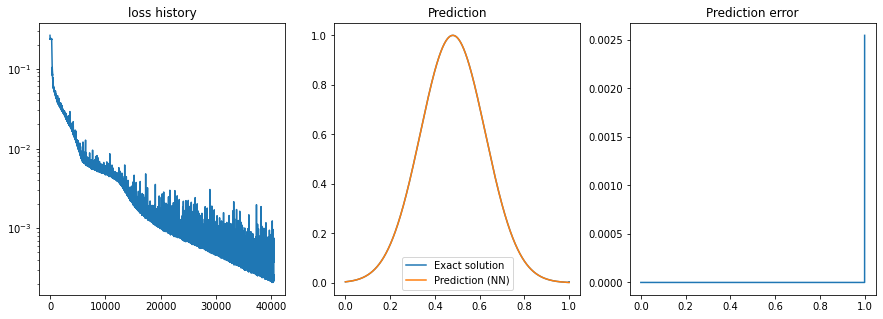

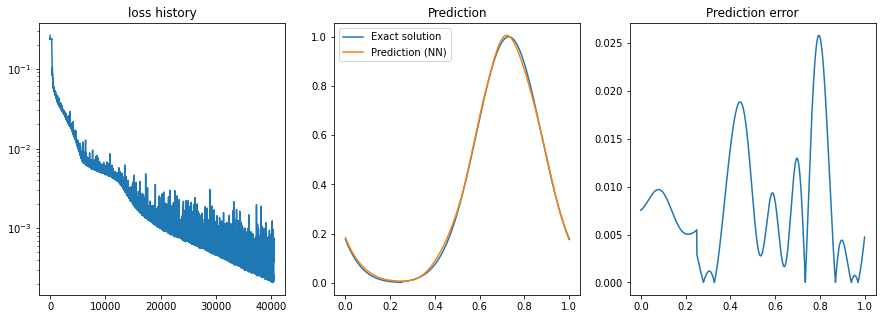

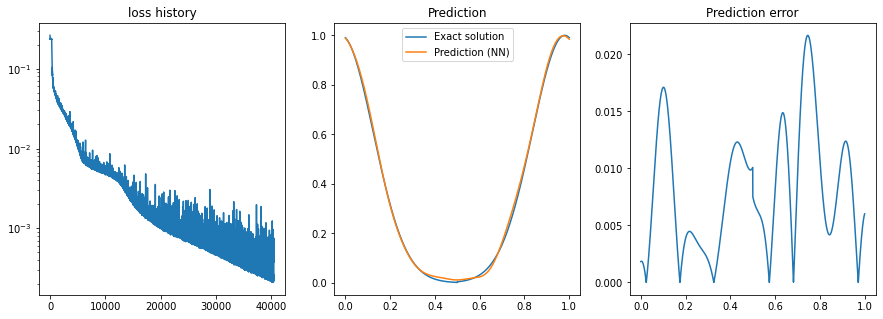

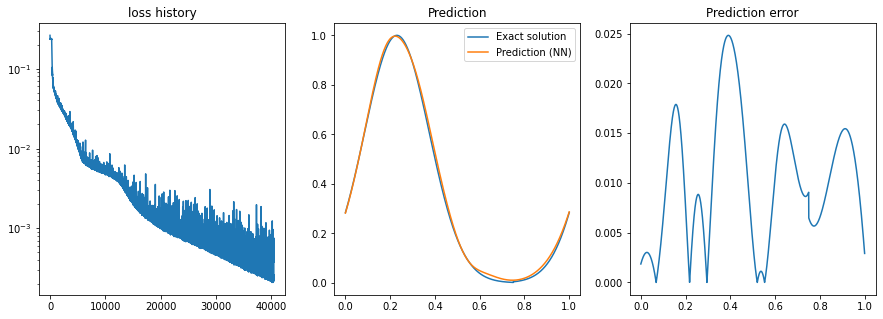

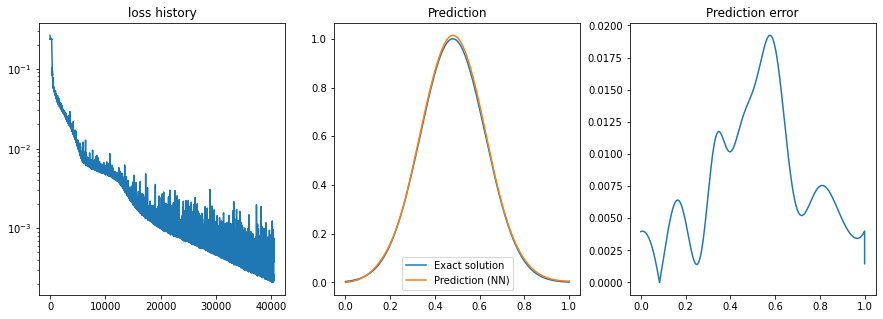

In [251]:
temps = [0., 0.25, 0.5, 0.75, 1.]
for t in temps:
    network_sup.plot(t, mean=0.48  ,variance=0.042)

### Usnupervised Learning

In [174]:
epocs = 40000
n_collocation =50000
n_data =0 
filename = "solution_unsupervised"

params = Parameters(1., file_name=filename)
network_un = Network(params)

network loaded successfully


#### NN Prediction

Error  9.728777465443475e-08
Error  0.012839854388424556
Error  0.16593668776503978
Error  0.33607346773464686
Error  0.3506757284612297


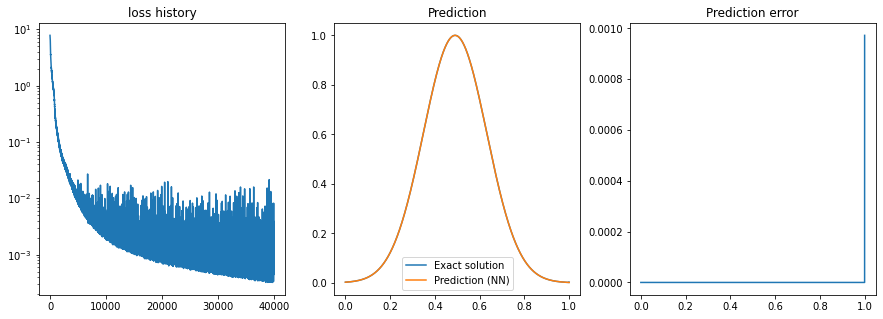

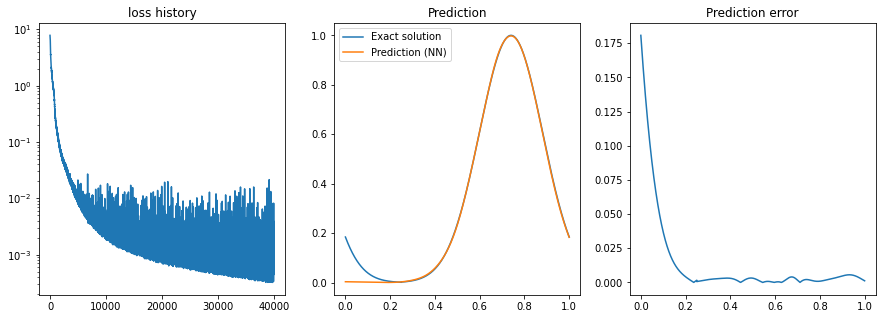

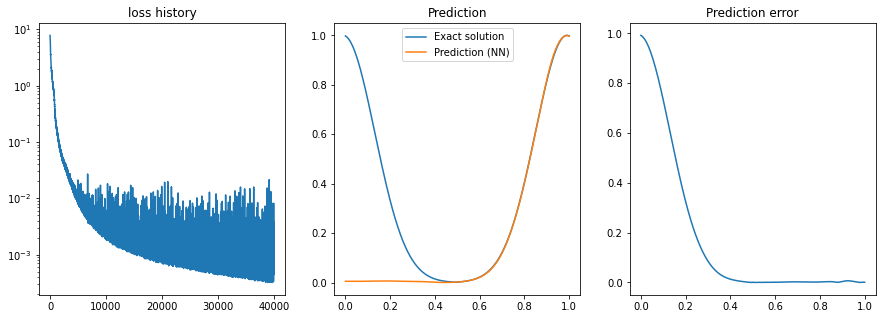

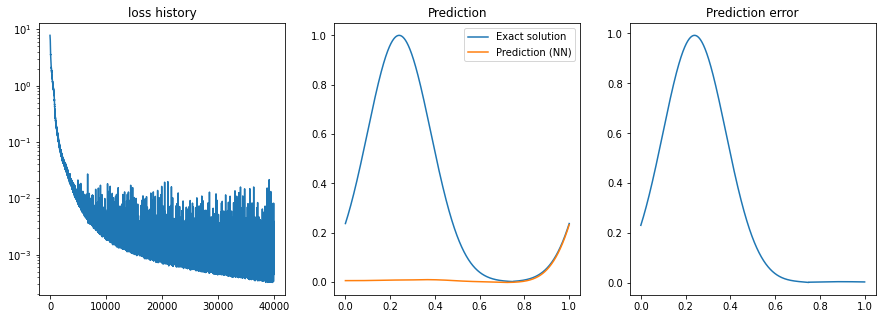

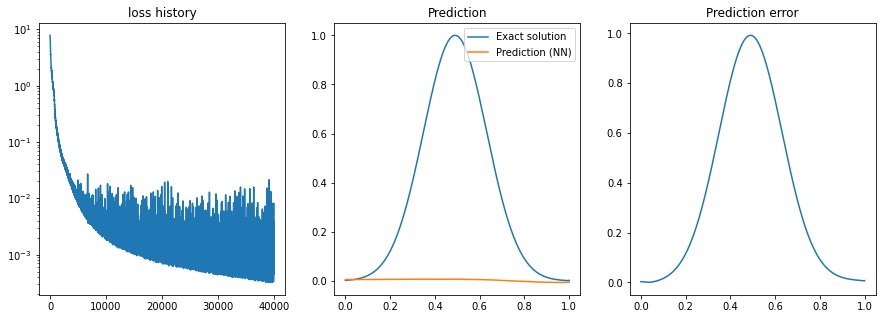

In [252]:
temps = [0., 0.25, 0.5, 0.75, 1.]
for t in temps:
    network_un.plot(t, mean=0.49 ,variance=0.04)

### Supervised and unsupervised Learning

In [176]:
epocs = 40000
n_collocation = 50000
n_data = 10000
filename = "solution"

params = Parameters(1., file_name=filename)
network = Network(params)

network loaded successfully


#### NN prediction

Error  0.0
Error  0.0019826578560727245
Error  0.0036238823379395784
Error  0.004355076218888088
Error  0.004178316822669265


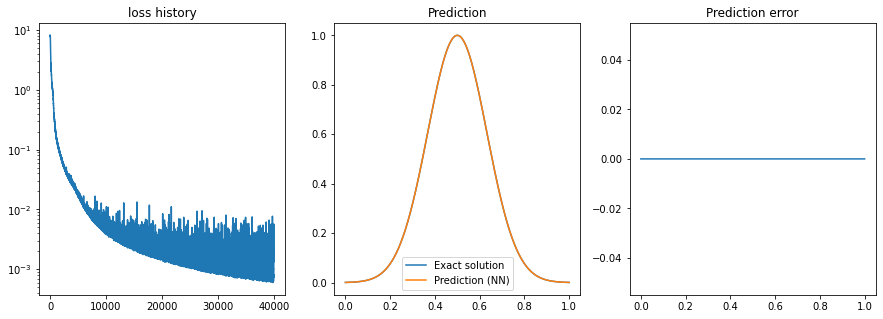

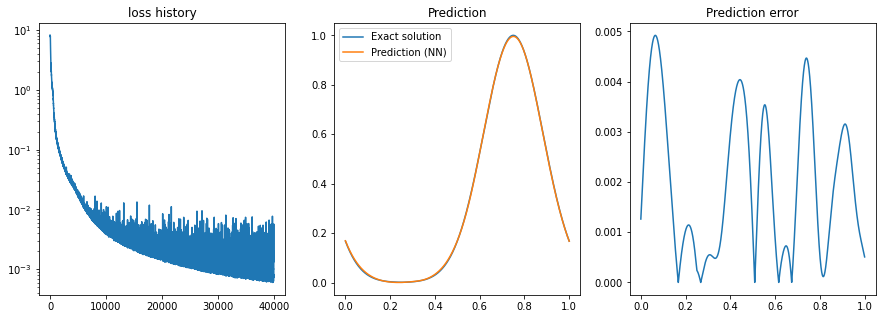

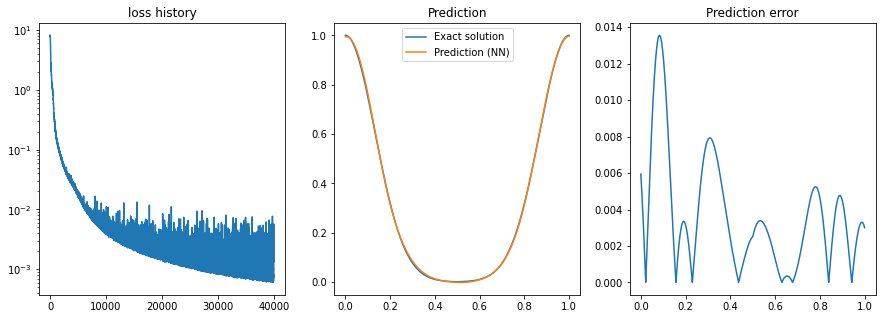

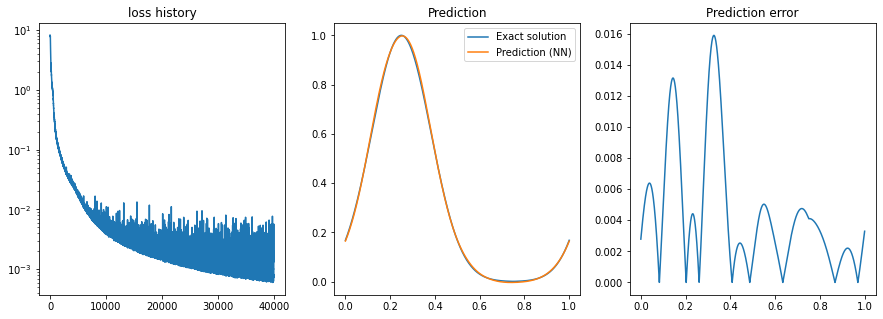

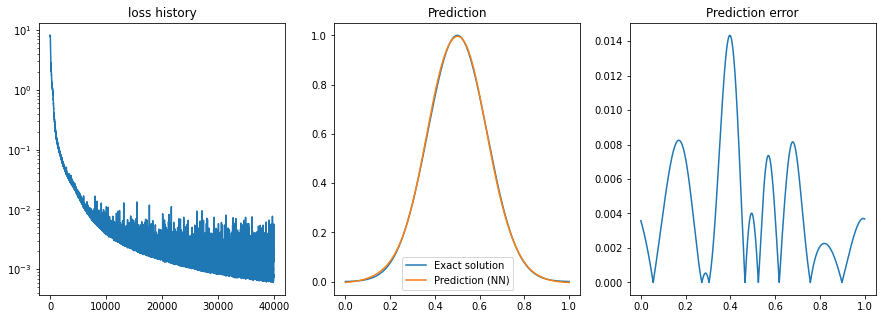

In [256]:
temps = [0., 0.25, 0.5, 0.75, 1.]
for t in temps:
    # network.plot(t, mean=0.49  ,variance=0.04)
    network.plot(t, mean=0.5  ,variance=0.035)

## Semi Lagrangian solver class

The semi-lagrangian scheme is given by the following formula:

$$
u\left(t_{n+1}, x_i\right)=\mathcal{I}_h^m\left(u\left(t_n, x\right)\right)\left(x_i-a \Delta t\right)
$$

The SemiLagrangianSolver class implements a numerical solver for simple transport equation using the Semi-Lagrangian method.

- `__init__(xmin, xmax, tmin, tmax, nx, nt, a, order, network)`: The constructor method initializes the solver with the given parameters. It sets up the spatial and temporal meshes, initializes solution arrays, and stores the necessary values for solving the transport equation. It also takes a network argument, which represents a neural network used for deep interpolation.

- `u_0(x)`: This method defines the initial condition u(t=0, x) for the transport equation. It returns the value of the initial condition at a given point x.

- `explicit_solution(x, t)`: This method calculates the exact solution of the transport equation at a given spatial point x and time t.

- `find_closest(index)`: This method calculates the order+1 closest points to a given point x_star (phantom point) based on the x_i point and returns the indexes found and the x_star point.

- `Li(x_star, x_closest, i)`: This method calculates the Lagrange basis polynomial L_i at x_star for the i-th closest point x_closest.

- `solver()`: This method solves the transport equation numerically using the Lagrange interpolation operator. It iterates over time and space to calculate the solution at each time step and spatial point.

- `u_theta(x, t)`: This method calculates the solution $u_\theta$ obtained by the neural network. It takes a spatial point x and time t as inputs and returns the predicted solution.

The Deep Lagrange interpolator is given by

$$
\mathcal{I}_d^m(f)=\sum_{i=1}^n \frac{f\left(x_i\right)}{u_{\theta_i}\left(x_i\right)} P_i(x) u_{\theta_i}(x)
$$

with $P_i\left(x_j\right)=\delta_{i j}$.

Using this choice, we obtain that $\mathcal{I}_d(f)\left(x_i\right)=f\left(x_i\right)$ as the classical interpolator.

- `solver_deep()`: This method solves the transport equation numerically using the deep Lagrange interpolation operator. It iterates over time and space to calculate the solution at each time step and spatial point using the u_theta method.

- `plot_solution(t)`: This method plots the numerical solution at a given time t along with the exact solution.

- `plot_solution_deep(t)`: This method plots the numerical solution obtained using deep interpolation at a given time t along with the exact solution and the solution obtained using the Lagrange interpolation operator.

- `error_solution(t)`: This method calculates the error of the numerical solution compared to the exact solution at a given time t.

- `error_inf_norm(deep)`: This method calculates the error in the infinity norm for both solutions (Lagrange interpolation and deep interpolation).

- `error_L2_norm(deep)`: This method calculates the error in the L2 norm for both solutions.

- `error_solution_deep(t)`: This method calculates the error of the numerical solution obtained using deep interpolation compared to the exact solution at a given time t.


In [231]:
"""A function that will create the mesh"""

def mesh (xmin, xmax, tmin, tmax, nx, nt):
    x = np.linspace(xmin, xmax, nx, endpoint=True)
    t = np.linspace(tmin, tmax, nt, endpoint=True)
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    return x, t, dx, dt

class SemiLagrangianSolver:

    def __init__(self, xmin, xmax, tmin, tmax, nx, nt, a, order,network, mean, variance,epsilon):
        
        self.xmesh, self.tmesh, self.delta_x, self.delta_t = mesh(xmin, xmax, tmin, tmax, nx, nt)

        self.xmax = xmax
        self.xmin = xmin
        self.tmax = tmax
        self.a = a #velocity
        self.nt=nt
        self.nx=nx
        self.u = np.zeros((nt, nx))
        self.u_deep = np.zeros((nt, nx))
        self.u_disturbed = np.zeros((nt, nx))
        self.order=order
        self.network = network
        self.mean = mean
        self.variance = variance
        self.epsilon = epsilon
    
    """Function that defines the u(t=0, x) initial condition"""

    def u_0(self, x):
        return np.exp(-(x-self.mean)**2/self.variance)
    

    """Function that calculates the explicit solution of the transport equation"""

    def explicit_solution(self, x, t): 
        if t==0:
            return self.u_0(x)
        else:
            return self.u_0((x - self.a * t) % self.xmax)



    """Function that calculates the closest points to the point x_star (phantom point) 
       based on the x_i point and returns the indexes and the x_star point"""

    def find_closest(self, index):
        
        x_i = self.xmesh[index]
        x_star = (x_i - self.a * self.delta_t) % self.xmax
        k = int(x_star / self.delta_x)

        indexes = np.zeros(self.order+1, dtype=int)
        indexes = np.arange(k - (self.order//2), k + (self.order//2) + 2)
        indexes = np.mod(indexes, self.nx)
        return indexes, x_star


    """Function that calculates the Lagrange basis polynomial Li at x_star"""
    
    def Li(self, x_star, x_closest, i):
        result = 1.0
        for j in range(len(x_closest)):
            if j != i:
                result *= (x_star - x_closest[j]) / (x_closest[i] - x_closest[j])
        return result

    """Function that calculates the numerical solution of the Transport equation 
       using de Lagrange interpolation operator"""
    def solver(self):  

        self.u[0,:] = self.u_0(self.xmesh)
        
        #We calculate the solution for each time step and each x_i point
        for t in range(self.nt-1):
            for i in range(self.nx):

                closest_indexes, x_star = self.find_closest(i)
                x_closest = self.xmesh[closest_indexes]
                u_closest = self.u[t, closest_indexes]
                li = np.zeros(self.order+1)
                
                for j in range(self.order+1):
                    li[j] = self.Li(x_star, x_closest, j)
                    
                u_sol = np.sum(u_closest*li)

                self.u[t+1,i] = u_sol   

        return self.u
    

    """u_thetai function""" 
    def u_theta(self, x, t):
        pred= self.network.predict_u_from_torch(x, t, self.mean, self.variance)
        return pred.detach().cpu().numpy() 
    
    def u_theta_disturbed(self, x, t):
        return self.explicit_solution(x, t) + self.epsilon*np.cos(x)

    """Function that calculates using the Deep Lagrange interpolation the numerical solution of the transport equation"""
    def solver_deep(self):
        self.u_deep[0,:] = self.u_0(self.xmesh)
        self.u_disturbed[0,:] = self.u_0(self.xmesh) #disturbed solution

        for t in range(self.nt-1):
            for i in range(self.nx):
                closest_indexes, x_star = self.find_closest(i) 
        
                x_closest = self.xmesh[closest_indexes] 
                x_closest_tensor = torch.tensor(x_closest.reshape(-1, 1), dtype=torch.float32).clone().detach() 
            
                u_closest = self.u_deep[t][closest_indexes] 
                u_closest_disturbed = self.u_disturbed[t][closest_indexes]
                
                u_theta_tensor = self.u_theta(x_closest_tensor, self.tmesh[t]) 
                u_theta_disturbed = self.u_theta_disturbed(x_closest, self.tmesh[t])
                
                u_theta_i=[]
                for k in range(len(u_theta_tensor)):
                    u_theta_i.append(u_theta_tensor[k].item())

                u_closest_theta = u_closest / u_theta_i
                u_closest_theta_disturbed = u_closest_disturbed / u_theta_disturbed
        
                li = np.zeros(self.order+1)
                li_disturbed = np.zeros(self.order+1)
                for j in range(self.order+1):
        
                    li[j] = self.Li(x_star, x_closest, j)
                    li_disturbed[j] = self.Li(x_star, x_closest, j)
            
                    x_star_tensor = torch.tensor(x_star.reshape(-1, 1), dtype=torch.float32).clone().detach() 
                    u_theta_tensor = self.u_theta(x_star_tensor, self.tmesh[t]) 
                    u_theta = u_theta_tensor.item()
                    
                    u_theta_disturbed = self.u_theta_disturbed(x_star, self.tmesh[t])
                    
                    li[j] *= u_theta
                    li_disturbed[j] *= u_theta_disturbed
                
                u_sol = np.sum(u_closest_theta * li)
                u_sol_disturbed = np.sum(u_closest_theta_disturbed * li_disturbed)
        
                self.u_deep[t+1][i] = u_sol
                self.u_disturbed[t+1][i] = u_sol_disturbed

        return self.u_deep, self.u_disturbed

    """Function that will show the plot of the solution at a given time t"""
    def plot_solution(self,t):
        plt.plot(self.xmesh, self.u[t,:], label = 'numerical solution')
        plt.plot(self.xmesh, self.explicit_solution(self.xmesh, self.tmesh[t]), label = 'exact solution')
        plt.title("Solution at time t = " + str(self.tmesh[t]))
        plt.grid()
        plt.xlabel("x")
        plt.ylabel("numerical solution")
        plt.legend()
        plt.show()
    

    """Function that will show the plot of the solution using deep interpolation at a given time t"""
    def plot_solution_deep(self,t):
        plt.plot(self.xmesh, self.u_deep[t,:], label = 'u deep with PINNs')
        plt.plot(self.xmesh, self.explicit_solution(self.xmesh, self.tmesh[t]), label = 'exact solution')
        plt.plot(self.xmesh, self.u[t,:], label = 'u')

        plt.title("Solution at time t = " + str(self.tmesh[t]))
        plt.grid()
        plt.xlabel("x")
        plt.ylabel("numerical solution deep")
        plt.legend()
        plt.show()
    
    def plot_solution_disturbed(self,t):
        plt.plot(self.xmesh, self.u_disturbed[t,:], label = 'u disturbed')
        plt.plot(self.xmesh, self.u_deep[t,:], label = 'u with PINNs')
        plt.plot(self.xmesh, self.explicit_solution(self.xmesh, self.tmesh[t]), label = 'exact solution')
        plt.plot(self.xmesh, self.u[t,:], label = 'u')

        plt.title("Solution at time t = " + str(self.tmesh[t]))
        plt.grid()
        plt.xlabel("x")
        plt.legend()
        plt.show()

        
    """ Function that will calculate the error of the numeral solution compared to the analytical solution at a given time t"""
    def error_solution(self, t):
        return np.sum(np.linalg.norm(self.u[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t]), ord=2))
     
    """Functions that will calculate the error in infinity norm for both solutions"""
    def error_inf_norm(self):
        diff = 0
        for t in range(1,self.nt):
            diff = np.abs(self.u[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t]))
            norm = np.max(diff)
        return norm

    def error_inf_norm_deep(self):
        diff = 0
        for t in range(1,self.nt):
            diff = np.abs(self.u_deep[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t]))
            norm = np.max(diff)
        return norm
    
    """Functions that will calculate the error in L2 norm for both solutions"""
    def error_L2_norm_deep(self, t):
        norm = 0
        diff = self.explicit_solution(self.xmesh, self.tmesh[t]) - self.u_deep[t, :]
        for j in range(self.nx):
            norm += (diff[j - 1] ** 2 + diff[j] ** 2) * self.delta_x / 2
        return norm

    def error_L2_norm(self, t):
        norm = 0
        diff = self.explicit_solution(self.xmesh, self.tmesh[t]) - self.u[t, :]
        for j in range(self.nx):
            norm += (diff[j - 1] ** 2 + diff[j] ** 2) * self.delta_x / 2
        return norm


    """ Function that will calculate the error of the numeral deep solution compared to the analytical solution at a given time t"""
    def error_solution_deep(self, t):
        if t > 0:
            return np.sum(np.linalg.norm(self.u_deep[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t]), ord=2))
        else:
            return 0
        
    """ Function that will calculate the error of the solution found with PINNs compared to the analytical solution at a given time t"""
    def NN_error(self, t):
        norm = 0
        u_theta=[]

        xmesh_tensor = torch.tensor(self.xmesh.reshape(-1, 1), dtype=torch.float32).clone().detach()
        u_theta_tensor = self.u_theta(xmesh_tensor, self.tmesh[t])
    
        for k in range(len(u_theta_tensor)):
            u_theta.append(u_theta_tensor[k].item())
        u_theta = np.array(u_theta)
        diff = (u_theta - self.explicit_solution(self.xmesh, self.tmesh[t]))
        
        for j in range(self.nx):
            norm += (diff[j - 1] ** 2 + diff[j] ** 2) * self.delta_x / 2
        return norm 
     
    """ Function that will calculate the error of the disturbed solution compared to the analytical solution at a given time t"""
    def error_solution_disturbed(self, t):
        norm = 0
        diff = self.explicit_solution(self.xmesh, self.tmesh[t]) - self.u_disturbed[t, :]
        for j in range(self.nx):
            norm += (diff[j - 1] ** 2 + diff[j] ** 2) * self.delta_x / 2
        return norm
    

### Solution using PINNs and deep Lagrange interpolation

In [233]:
"""We first define the values of the parameters of the solver """
xmin = 0.
xmax = 1.
tmin = 0.   
tmax = 1.
nx = 100
nt = 100
a=1
         
solver = SemiLagrangianSolver(xmin, xmax, tmin, tmax, nx, nt, a, 3, network, mean=0.5, variance=0.035, epsilon=0.0)
X = solver.xmesh
T = solver.tmesh

"""We verify the CFL condition"""
print("cfl solver" , a*solver.delta_t/solver.delta_x)

"""Solutions of the problem"""
u_semilag = solver.solver()
u_semilag_deep, u_semilag_disturbed = solver.solver_deep()

"""Exact solution"""
u_exact = np.zeros((solver.nt, solver.nx))
for i in range(solver.nt):
    for j in range(solver.nx):
        u_exact[i,j] = solver.explicit_solution(X[j], T[i])

cfl solver 1.0


### Visualization of the solution

In [234]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

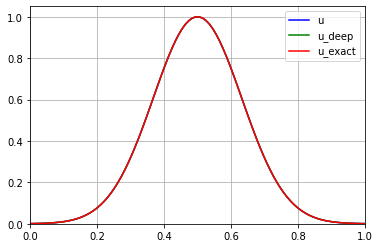

In [235]:
fig, ax = plt.subplots()
line_u_semilag, = ax.plot([], color='blue', label='u')
line_u_semilag_deep, = ax.plot([], color='green', label='u_deep')
line_exact, = ax.plot([], color='red', label='u_exact')
ax.grid()
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.05)
ax.legend()

def animate(frame_num):
    line_u_semilag.set_data(X, u_semilag[frame_num,:])
    line_u_semilag_deep.set_data(X, u_semilag_deep[frame_num,:])
    line_exact.set_data(X, u_exact[frame_num,:])
    return line_u_semilag, line_u_semilag_deep, line_exact

anim_bis = FuncAnimation(fig, animate, frames=solver.nt, interval=120, blit=True)
anim_bis.save("animation" + str(solver.mean) + ".gif", writer='pillow')

## $L^{2}$ error study


#### SL Lagrange interpolation vs SL deep interpolation vs NN solution

t  25 0.25252525252525254
L2 error SL 5.099939272774036e-07
L2 error SL deep 5.0121888685414026e-08
L2 error reseau 6.213524973465301e-06
t  50 0.5050505050505051
L2 error SL 1.959092300981657e-06
L2 error SL deep 2.524584959118078e-07
L2 error reseau 2.455244656588844e-05
t  99 1.0
L2 error SL 6.649461937199656e-06
L2 error SL deep 2.7525703781568854e-06
L2 error reseau 4.037036507192593e-05


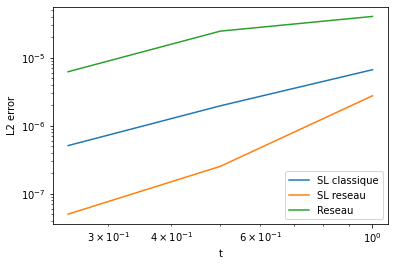

In [264]:
xmin = 0.
xmax = 1.
tmin = 0. 
tmax = 1.
nx = 40
nt = 100
a=1
mean = 0.48
variance = 0.042

time_steps= [tmax/4, tmax/2, tmax]
time_steps_indexes = [nt//4, nt//2, nt-1]

error_reseau = []
error_sl_classique = []
error_sl_reseau = []

solver_prime = SemiLagrangianSolver(xmin, xmax, tmin, tmax, nx, nt, a, 3, network, mean, variance, epsilon=0.0)
u_sol = solver_prime.solver()
u_sol_deep = solver_prime.solver_deep()

for t in time_steps_indexes:
    print("t ", t, solver_prime.tmesh[t])
    
    #Calcul de l'erreur en norme L2
    error_L2_norm_sl = solver_prime.error_L2_norm(t)
    print("L2 error SL", error_L2_norm_sl)
    
    error_L2_norm_deep = solver_prime.error_L2_norm_deep(t)
    print("L2 error SL deep", error_L2_norm_deep)

    error_du_reseau = solver_prime.NN_error(t)
    print("L2 error reseau", error_du_reseau)

    error_sl_classique.append(error_L2_norm_sl)
    error_sl_reseau.append(error_L2_norm_deep)
    error_reseau.append(error_du_reseau)

#Graphique de l'erreur en norme L2
plt.plot(time_steps, error_sl_classique, label='SL classique')
plt.plot(time_steps, error_sl_reseau, label='SL reseau')
plt.plot(time_steps, error_reseau, label='Reseau')
plt.xlabel('t')
plt.ylabel('L2 error')
plt.loglog()
plt.legend()
plt.show()

#### Slope of the error

In [237]:
#Slope calculation
error_sl_classique.pop(0)
error_sl_reseau.pop(0)
error_reseau.pop(0)

slope_sl_classique = (np.log(error_sl_classique[1]) - np.log(error_sl_classique[0])) / (np.log(time_steps[1]) - np.log(time_steps[0]))
slope_sl_reseau = (np.log(error_sl_reseau[1]) - np.log(error_sl_reseau[0])) / (np.log(time_steps[1]) - np.log(time_steps[0]))
slope_reseau = (np.log(error_reseau[1]) - np.log(error_reseau[0])) / (np.log(time_steps[1]) - np.log(time_steps[0]))
print("Slope SL classique", slope_sl_classique)
print("Slope SL reseau", slope_sl_reseau)
print("Slope reseau", slope_reseau)

Slope SL classique 0.9328656194879076
Slope SL reseau 2.9783575068280483
Slope reseau 0.6281345689950817


#### SL Lagrange interpolation vs SL deep interpolation vs NN solution vs SL perturbed solution

##### Interpolation of 1st order

epsilon 0.0001
t 25
L2 error SL 0.0013970507724709376
L2 error SL deep 1.2729274348892172e-06
L2 error reseau 6.213524973465301e-06
L2 error perturbee 2.432537478667212e-09 perturbation =  0.0001
t 50
L2 error SL 0.005056025216616563
L2 error SL deep 7.2323146235298415e-06
L2 error reseau 2.455244656588844e-05
L2 error perturbee 1.1034070123448931e-08 perturbation =  0.0001
t 99
L2 error SL 0.013033855863027239
L2 error SL deep 4.439851647123094e-05
L2 error reseau 4.037036507192593e-05
L2 error perturbee 9.040837723908755e-07 perturbation =  0.0001
epsilon 0.001
t 25
L2 error SL 0.0013970507724709376
L2 error SL deep 1.2729274348892172e-06
L2 error reseau 6.213524973465301e-06
L2 error perturbee 1.797095160705542e-07 perturbation =  0.001
t 50
L2 error SL 0.005056025216616563
L2 error SL deep 7.2323146235298415e-06
L2 error reseau 2.455244656588844e-05
L2 error perturbee 8.239309463554773e-07 perturbation =  0.001
t 99
L2 error SL 0.013033855863027239
L2 error SL deep 4.43985164712309

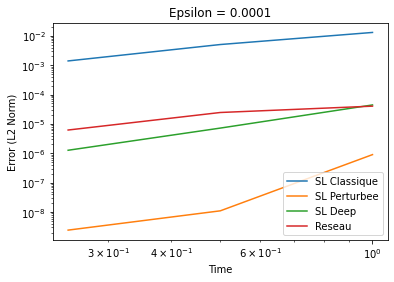

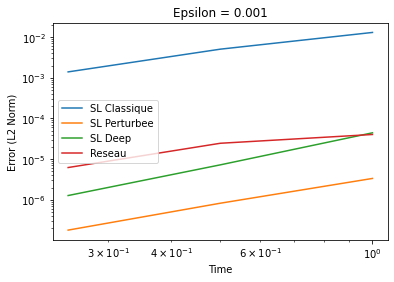

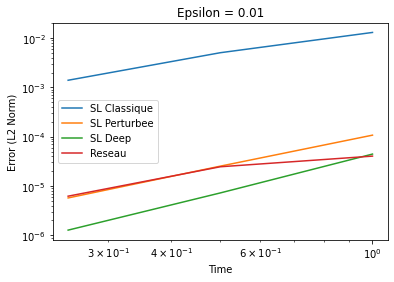

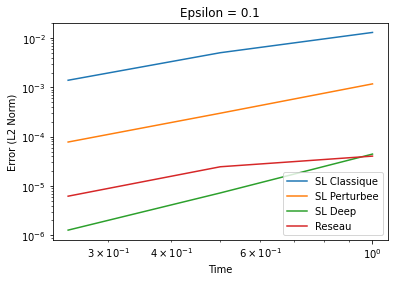

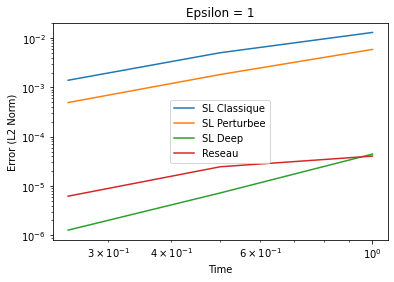

In [238]:
xmin = 0.0
xmax = 1.0
tmin = 0.0   
tmax = 1.0
nx = 40
nt = 100 
a = 1
mean = 0.48
variance = 0.042

time_steps = [tmax/4, tmax/2, tmax]
time_steps_indexes = [nt//4, nt//2, nt-1]

error_sl_classique = []
error_sl_perturbee = []
error_sl_deep = []
error_reseau = []

for epsilon in [0.0001, 0.001, 0.01, 0.1, 1]:
    print("epsilon", epsilon)
    for t in time_steps_indexes:
        print("t", t)
        solver_prime = SemiLagrangianSolver(xmin, xmax, tmin, tmax, nx, nt, a, 1, network, mean, variance, epsilon) #Order oF Lagrange interpolation = 2
    
        u_sol = solver_prime.solver()
        u_sol_deep = solver_prime.solver_deep()
        
        # Calculating the error in L2 norm
        error_L2_norm_sl = solver_prime.error_L2_norm(t)
        print("L2 error SL", error_L2_norm_sl)
        error_L2_norm_deep = solver_prime.error_L2_norm_deep(t)
        print("L2 error SL deep", error_L2_norm_deep)
        error_du_reseau = solver_prime.NN_error(t)
        print("L2 error reseau", error_du_reseau)
        error_l2_perturbee = solver_prime.error_solution_disturbed(t)
        print("L2 error perturbee", error_l2_perturbee, "perturbation = ", str(epsilon))

        error_sl_classique.append(error_L2_norm_sl)
        error_sl_deep.append(error_L2_norm_deep)
        error_reseau.append(error_du_reseau)
        error_sl_perturbee.append(error_l2_perturbee)
        
# Plotting the graphs
for i, epsilon in enumerate([0.0001, 0.001, 0.01, 0.1, 1]):
    plt.figure(i+1)
    plt.plot(time_steps, error_sl_classique[i*len(time_steps):(i+1)*len(time_steps)], label='SL Classique')
    plt.plot(time_steps, error_sl_perturbee[i*len(time_steps):(i+1)*len(time_steps)], label='SL Perturbee')
    plt.plot(time_steps, error_sl_deep[i*len(time_steps):(i+1)*len(time_steps)], label='SL Deep')
    plt.plot(time_steps, error_reseau[i*len(time_steps):(i+1)*len(time_steps)], label='Reseau') 
    plt.loglog()
    plt.xlabel('Time')
    plt.ylabel('Error (L2 Norm)')
    plt.title(f'Epsilon = {epsilon}')
    plt.legend()

# Show all the graphs
plt.show()

##### Interpolation of 3rd order

epsilon 0.0001
t 25
L2 error SL 5.099939272774036e-07
L2 error SL deep 5.0121888685414026e-08
L2 error reseau 6.213524973465301e-06
L2 error perturbee 1.2845654969976448e-10 perturbation =  0.0001
t 50
L2 error SL 1.959092300981657e-06
L2 error SL deep 2.524584959118078e-07
L2 error reseau 2.455244656588844e-05
L2 error perturbee 2.8745450500511723e-10 perturbation =  0.0001
t 99
L2 error SL 6.649461937199656e-06
L2 error SL deep 2.7525703781568854e-06
L2 error reseau 4.037036507192593e-05
L2 error perturbee 7.327343224612364e-07 perturbation =  0.0001
epsilon 0.001
t 25
L2 error SL 5.099939272774036e-07
L2 error SL deep 5.0121888685414026e-08
L2 error reseau 6.213524973465301e-06
L2 error perturbee 6.751720503892382e-09 perturbation =  0.001
t 50
L2 error SL 1.959092300981657e-06
L2 error SL deep 2.524584959118078e-07
L2 error reseau 2.455244656588844e-05
L2 error perturbee 1.5900171921494064e-08 perturbation =  0.001
t 99
L2 error SL 6.649461937199656e-06
L2 error SL deep 2.752570378

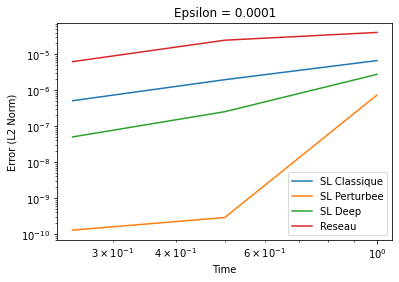

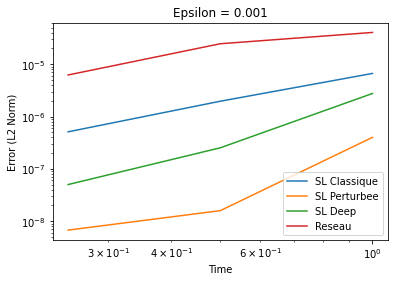

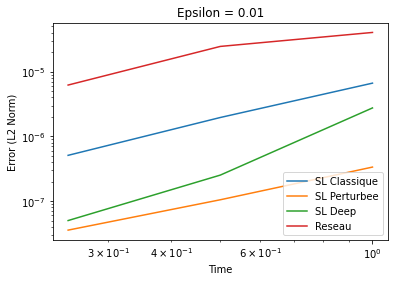

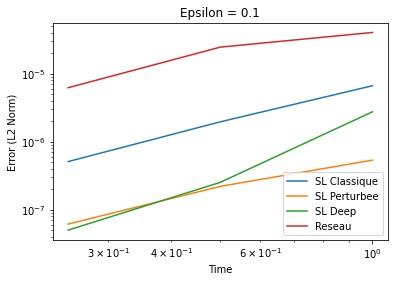

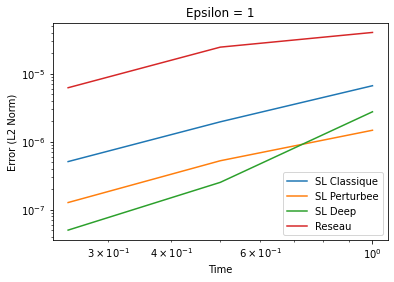

In [243]:
xmin = 0.0
xmax = 1.0
tmin = 0.0   
tmax = 1.0
nx = 40
nt = 100 
a = 1
mean = 0.48
variance = 0.042

time_steps = [tmax/4, tmax/2, tmax]
time_steps_indexes = [nt//4, nt//2, nt-1]

error_sl_classique = []
error_sl_perturbee = []
error_sl_deep = []
error_reseau = []

for epsilon in [0.0001, 0.001, 0.01, 0.1, 1]:
    print("epsilon", epsilon)
    for t in time_steps_indexes:
        print("t", t)
        solver_prime = SemiLagrangianSolver(xmin, xmax, tmin, tmax, nx, nt, a, 3, network, mean, variance, epsilon) #Order oF Lagrange interpolation = 2
    
        u_sol = solver_prime.solver()
        u_sol_deep = solver_prime.solver_deep()
        
        # Calculating the error in L2 norm
        error_L2_norm_sl = solver_prime.error_L2_norm(t)
        print("L2 error SL", error_L2_norm_sl)
        error_L2_norm_deep = solver_prime.error_L2_norm_deep(t)
        print("L2 error SL deep", error_L2_norm_deep)
        error_du_reseau = solver_prime.NN_error(t)
        print("L2 error reseau", error_du_reseau)
        error_l2_perturbee = solver_prime.error_solution_disturbed(t)
        print("L2 error perturbee", error_l2_perturbee, "perturbation = ", str(epsilon))

        error_sl_classique.append(error_L2_norm_sl)
        error_sl_deep.append(error_L2_norm_deep)
        error_reseau.append(error_du_reseau)
        error_sl_perturbee.append(error_l2_perturbee)
        
# Plotting the graphs
for i, epsilon in enumerate([0.0001, 0.001, 0.01, 0.1, 1]):
    plt.figure(i+1)
    plt.plot(time_steps, error_sl_classique[i*len(time_steps):(i+1)*len(time_steps)], label='SL Classique')
    plt.plot(time_steps, error_sl_perturbee[i*len(time_steps):(i+1)*len(time_steps)], label='SL Perturbee')
    plt.plot(time_steps, error_sl_deep[i*len(time_steps):(i+1)*len(time_steps)], label='SL Deep')
    plt.plot(time_steps, error_reseau[i*len(time_steps):(i+1)*len(time_steps)], label='Reseau') 
    plt.loglog()
    plt.xlabel('Time')
    plt.ylabel('Error (L2 Norm)')
    plt.title(f'Epsilon = {epsilon}')
    plt.legend()

# Show all the graphs
plt.show()

### Average gain of the error in $L^2$ norm

In [244]:

xmin = 0.0
xmax = 1.0
tmin = 0.0   
tmax = 1.0
nx = 20
nt = 100 
a = 1

np.random.seed()

random_means = np.random.uniform(0.45, 0.55, 30)
random_variances = np.random.uniform(0.01, 0.05, 30)

time_steps = [tmax/4, tmax/2, tmax]
time_steps_indexes = [nt//4, nt//2, nt-1]

error_sl_classique = []
error_sl_deep = []
gains = []

for mean, variance in zip(random_means, random_variances):
    for t in time_steps_indexes:

        solver_prime = SemiLagrangianSolver(xmin, xmax, tmin, tmax, nx, nt, a, 3, network, mean, variance, epsilon) #Order oF Lagrange interpolation = 2
    
        u_sol = solver_prime.solver()
        u_sol_deep,_= solver_prime.solver_deep()

        # Calculating the error in L2 norm
        error_L2_norm_sl = solver_prime.error_L2_norm(t)
        error_sl_classique.append(error_L2_norm_sl)
        error_L2_norm_deep = solver_prime.error_L2_norm_deep(t)
        error_sl_deep.append(error_L2_norm_deep)

    #total L2 error for all time steps
    L2_error_sl = np.sum(error_L2_norm_sl)
    L2_error_sl_deep = np.sum(error_L2_norm_deep)

    gain = L2_error_sl/L2_error_sl_deep
    gains.append(gain)

# Average gain
average_gain = np.mean(gains)

print("Average gain", average_gain)

Average gain 1.9229058111852473
